data not transformed, fit to a linear model

classes and functions 

In [1]:
#this contains the information for a patient class
#creates a class for patients so we can call information about them easily
class patient:
    def __init__(self, filepath, input_fileName, lengthPtID):
        ptID = input_fileName[:lengthPtID]
        self.ptID = ptID
        self.fileName = input_fileName
        #find the demographics in one of two sheets
        # directory = os.getcwd()
        file_adds = filepath + '/' + input_fileName
        file = pd.ExcelFile(file_adds)
        sheet_Names = file.sheet_names
        if 'Cancer_Registery Data' in sheet_Names:
            #do the thing for getting patient info
            df = pd.read_excel(input_fileName, sheet_name= 'Cancer_Registery Data')
            self.ptDemographics = df
            self.amyloid_status = df.at[0,"Amyloid Status"]
            self.survival = df.at[0,"Survival Time (Months)"]
            self.ageDx = df.at[0,"Age At Diagnosis"] 
            self.sex = df.at[0,"Gender Cancer Registry"]
            self.vitalStatus = df.at[0, "Vital Status Cancer Registry"]
            self.dx = df.at[0, "Histology"]

        elif '30 Cerner Patients ' in sheet_Names:
            #do the thing for getting patient info
            df = pd.read_excel(input_fileName, sheet_name= '30 Cerner Patients ')
            self.ptDemographics = df
            self.amyloid_status = df.at[0,"Amyloid Status"]
            self.survival = df.at[0,"Survival Time (months)"]
            self.ageDx = df.at[0,"Age At Diagnosis"] 
            self.sex = df.at[0,"Gender Cerner"]
            self.vitalStatus = df.at[0, "Vital Status (Cerner)"]
            self.dx = df.at[0, "Primary Site"]


        else: print("no patient identifying information")

        #now iterate through the list of sheets to import the patient data 
        if 'Labs' in sheet_Names:
            self.labsData = pd.read_excel(input_fileName, sheet_name= 'Labs')
        else: self.labsData = False
        
        if 'amyloid in subject' in sheet_Names:
            self.echoData = pd.read_excel(input_fileName, sheet_name= 'amyloid in subject')
        else: self.echoData = False

        if 'ChemoTx' in sheet_Names:
            self.ChemoTx = pd.read_excel(input_fileName, sheet_name= 'ChemoTx')
        else: self.ChemoTx = False

        if 'Hematologic Tx' in sheet_Names:
            self.HemeTx = pd.read_excel(input_fileName, sheet_name= 'Hematologic Tx')
        else: self.HemeTx = False

        if 'Immuno Tx' in sheet_Names:
            self.HemeTx = pd.read_excel(input_fileName, sheet_name= 'Immuno Tx')
        else: self.ImmunoTx = False

        if 'Radiation Tx' in sheet_Names:
            self.RadTx = pd.read_excel(input_fileName, sheet_name= 'Radiation Tx')
        else: self.ImmunoTx = False

        if 'Physican_Notes' in sheet_Names:
            self.MDnotes = pd.read_excel(input_fileName, sheet_name= 'Physican_Notes')
        else: self.MDnotes = False

        #to create a callable list of treatments recieved for which we have data
        tx_sheets = ['ChemoTx', 'Hematologic Tx', 'Immuno Tx']
        treatmentTypesRecieved = []

        for possible in tx_sheets:
        
            if possible in sheet_Names:
                treatmentTypesRecieved.append(possible)
        self.txRecieved = treatmentTypesRecieved

In [2]:
def FilterList(list, keyWords_primary, keyWords_secondary = ["Empty"], omit = ["Empty"]):
    #store the filtered result
    filteredList = []

    if keyWords_secondary == ["Empty"]:
        for c in list: #loop the columns
            for buzz in keyWords_primary: #loop the key words
                if buzz in c: #if the column contains the key word
                    filteredList.append(c) #add the column to the list
                    break #do not continue testing primary key words for this column
    
    else: 
        for c in list: #loop the columns
            for buzz in keyWords_primary: #loop the key words
                if buzz in c: #if the column contains the key word
                    for secondary in keyWords_secondary:
                        if secondary in c:
                            filteredList.append(c) #add the column to the list
                            break #has been added to list based on passing the seondary 
                        else:
                            pass
                    break #do not continue to check primary key words for this column
                else:
                    pass
                
    if omit != ["Empty"]: 
        for x in omit: 
            for a in filteredList:
                if x in a:
                    filteredList.remove(a)
    
    #by iterating through the column names first, we keep the order of the columns

    return filteredList 


In [3]:
#get amyloid status dictionary inputs, sort ptIDs to lists based on amyloid status 
def getListSortedByAmyloid(amyloidDictionary, listPositive, listNegative, listOther,
                           statusPositive = "yes", statusNegative = "no"):
    for pt in amyloidDictionary.keys():
        status = amyloidDictionary[pt]
        if status == statusPositive:
            listPositive.append(pt)
        elif status == statusNegative:
            listNegative.append(pt)
        else:
            listOther.append(pt)
    #does not check for double listed patient IDs

In [4]:
def GetListofPTfiles(directory, fileExtension, fileCommon):
    listFileNames = os.listdir(directory)
    outListFiles = []
    #loop through file names
    for file in listFileNames:
        if fileCommon in file and file.endswith(fileExtension):
            outListFiles.append(file)
    return outListFiles

In [5]:
#function for masking a dataframe 
def patientSectionOfFrame(start_frame, sheet_name, column_toMask, ptID):
    #ptID is a row parameter in the column_toMask
    df_use = start_frame #copy of the frame

    #first check if sheet has the column of interest
    data_top = list(start_frame.columns) #returns the headers as a list

    #determine of the sheet contains the column of interest
    if data_top.count(column_toMask) > 0: 
        #if true, now find if the patient is present
        searchForPt = start_frame[column_toMask].str.startswith(ptID).sum() #returns the number of instances of the patient
        if searchForPt > 0:
            #patient is present 
            #mask the data for the patient
            df_clean = df_use.dropna(subset= [column_toMask]) #removing NA 
            mask = df_clean[column_toMask].str.startswith(ptID) #masking for the rows where the patient has data
            df_sub_tosave = df_clean[mask] #output dataframe filtered for the patient
            return df_sub_tosave
        else:
            #the patient isn't present
            # return print("The patient " + ptID + " is not in " + sheet_name)
            pass
    else:
        #the column of interest isn't present
        # return print("The column " + column_toMask + " is not in the sheet " + sheet_name)
        pass



In [6]:
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

libraries and directory

In [7]:
#libraries and dirrectory 
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit


In [8]:
#location of original data
starting_directory = os.getcwd()

new_dirrectory = 'C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/data-2024-06-05'
os.chdir(new_dirrectory)

In [33]:
#locations for the output data spreadsheets
#dirrectory and file information for where you want to save outputs
#making new path for saving output

dateTag = "_2024-06-17"
#make dirrectory for saving files 
parent_dir = new_dirrectory
folderName = "singleLab-Fits" + dateTag
path = os.path.join(parent_dir,folderName)
if not os.path.exists(path):
    os.mkdir(path)

#for dirrectory
patientFitsDir = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/data-2024-06-05/singleLab-Fits_2024-06-17"
patientFitsFolder = "by-pt"


#for files
folderNameFiles = "by-pt"
dataOut_common = "-fitData"
dataOut_suffix = "_2024-06-17"
dataOut_sheetName = "expfit-20240625"

In [34]:
#locations for the ouput figures
#for figures
parent_dir_fig = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/013 Analyzed Data outputs"
folderName_QuadFitFigures = makeFolderPathForData(parent_dir_fig, "FitFig-", "exp", "_2024-06-25-v1")
parent_dir_fig2 = os.path.join(parent_dir_fig, folderName_QuadFitFigures)
# fileName_header_fig = #patient ID
# fileName_mid_fig = #lab name
fileName_suff_fig = "-expfitFig"
#output figures
# outputFiguresPath(fileName_header= fileName_header_fig, fileName_mid= fileName_mid_fig, fileName_suff= fileName_suff_fig,
#                   parent_dir=parent_dir_fig2, folderName= make a folder)

importing orginal data and sorting to dictionaries


In [11]:
#importing patient data as dictionaries of dataframes
ptID_test = "E-01"

#build a dictionary of patients and their values 
ptFiles = GetListofPTfiles(new_dirrectory, '.xlsx', 'data')

patientDictAmyloid = {}
patientDictSurvival = {}
patientDictLabs = {}
patientDictEcho = {}
patientDictNotes = {}
patientDictDx = {}
patientDictVitalStatus = {}

#loop through the listOfPatients 
for file in ptFiles: 
    pt = patient(new_dirrectory, file, 4)
    patientDictAmyloid[pt.ptID] = pt.amyloid_status
    patientDictSurvival[pt.ptID] = pt.survival
    patientDictLabs[pt.ptID] = pt.labsData
    patientDictEcho[pt.ptID] = pt.echoData
    patientDictNotes[pt.ptID] = pt.MDnotes
    patientDictDx[pt.ptID] = pt.dx
    patientDictVitalStatus[pt.ptID] = pt.vitalStatus
    

#calling patient to test 
ptLabsTest = patientDictLabs[ptID_test]

In [12]:
EchoTimeColumn ='time from diagnosis to first echo (months)'
echoDates = {}
for pt in patientDictEcho:
    ptEchoData = patientDictEcho[pt]
    patientEchoDate = ptEchoData[EchoTimeColumn]
    if 'none' not in list(patientEchoDate):
        echoDates[pt] = patientEchoDate

In [13]:
# keywords_Primary = ["BUN", "Albumin Result", "Creatinine Result",
#                     "Hemoglobin", "Platelet Count", "INR", "Kappa Free Light Chains",
#                     "Lambda Free Light Chains", "Free Light Chain Ratio",
#                     "Total Urine Protein", "Urine Albumin", "Urinalysis Alpha1", "Urinalysis Alpha2",
#                     "Urinaysis Beta Globulin", "Urinalysis Gamma Golubulin", "Urinalysis M Spike", "BNP",
#                     "Troponin-T", "Beta-2", "LDH", "Uric Acid", "Serum Protein", "WBC", "Blast",
#                     "Coombs", "Immature Gran", "Monocyte", "Neutrophil", "RBC", "Serum Electrophoresis",
#                     "Serum Immunologic", "Urine Osmolality", "Urine Specific Gravity"]

In [14]:
#list of columns to use with clinical significance
#using this list will not enable collection of normal ranges as it lists specific lab columns
#to collect normal values, make a key word list instead.

keywords_Primary = ["Total Serum Protein Result",
                "Albumin Result(gm/dL)",
                "Kappa Free Light Chains Result (mg/L)",
                "Kappa/Lambda Free Light Chain Ratio Result",
                "Lambda Free Light Chains Result (mg/L)",
                "Serum Electrophoresis M Spike Result",
                "Beta-2-Microglobulin Result", 
                "Total Urine Protein Outcome Un Result",
                "Creatinine Result(mg/dL)",
                "BUN Result(mg/dL)", "LDH Result(U/L)",
                "WBC Result(k/uL)", "RBC Result", 
                "Pct. Immature Gran Auto Result",
                "NT Pro BNP (B-Type Natriuretic Peptide)",
                "Troponin-T"
]

# miniLabsTest = ["Total Serum Protein Result",
#                 "Albumin Result(gm/dL)",
#                 "Kappa Free Light Chains Result (mg/L)",
#                 "Kappa/Lambda Free Light Chain Ratio Result",
#                 "Lambda Free Light Chains Result (mg/L)",
#                 "Serum Electrophoresis M Spike Result",
#                 "Beta-2-Microglobulin Result", 
#                 "Total Urine Protein Outcome Un Result",
#                 "Creatinine Result(mg/dL)",
#                 "BUN Result(mg/dL)", "LDH Result(U/L)",
#                 "WBC Result(k/uL)", "RBC Result", 
#                 "Pct. Immature Gran Auto Result",
#                 "NT Pro BNP (B-Type Natriuretic Peptide)",
#                 "Troponin-T"
# ]

In [15]:
#normal ranges 
dictUpperLimit = {
    "Total Serum Protein Result" : 8,
    "Albumin Result(gm/dL)": 5,
    "Kappa Free Light Chains Result (mg/L)": 19.4, 
    "Kappa/Lambda Free Light Chain Ratio Result": 1.65, 
    "Lambda Free Light Chains Result (mg/L)": 26.6, 
    "Beta-2-Microglobulin Result" : 2.2, 
    "Total Urine Protein Outcome Un Result": 150, 
    "Creatinine Result(mg/dL)": 1.3,
    "BUN Result(mg/dL)": 20, 
    "LDH Result(U/L)": 280, 
    "WBC Result(k/uL)": 11,
    "RBC Result": 5.9, #using the values for males here
    "NT Pro BNP (B-Type Natriuretic Peptide)": 900, #upper limit for patients over 50
    "Troponin-T": 0.01
}

dictLowerLimit = {
    "Total Serum Protein Result": 6,
    "Albumin Result(gm/dL)": 3.5, 
    "Kappa Free Light Chains Result (mg/L)": 3.3,
    "Kappa/Lambda Free Light Chain Ratio Result" : 0.26, 
    "Lambda Free Light Chains Result (mg/L)": 5.7, 
    "Beta-2-Microglobulin Result" : 0.8, 
    "Creatinine Result(mg/dL)": 0.7,
    "BUN Result(mg/dL)" : 8, 
    "LDH Result(U/L)" : 140, 
    "WBC Result(k/uL)": 4, 
    "RBC Result": 4.3, #using the value for males here
    "NT Pro BNP (B-Type Natriuretic Peptide)": 450, #actually the upper limit for patients under 50
}

In [16]:
#dictionary for the filtered data
#this enables filtering of the patient data as its own block of code
dictOfFilteredLabs = {}
dictOfNormalRanges = {}

#other input values to set outside of loop 
x_column_name = "RelTime(Days)"

In [17]:
#collecting and filtering single patient
#to collect and filter the patient labs into a dictionary
df_Labs = patientDictLabs[ptID_test]

orig_columns = df_Labs.columns

#filter the patient labs
columnNames = FilterList(orig_columns, keyWords_primary = keywords_Primary, keyWords_secondary=['Result'], 
                            omit = ['Method','Nucleated', '100'])
testNames = [x_column_name]
testNames.extend(columnNames) #addition of time label

ptLabs_results= df_Labs[testNames] #new data frame of just results

#troponin contains strings which mess up plotting 
df_Labs_results_2 = ptLabs_results
for col in columnNames:
    df_Labs_results_2[col] = ptLabs_results[col].apply(lambda x: 0 if isinstance(x, str) else x)
ptLabs_results_2 = df_Labs_results_2
dictOfFilteredLabs[ptID_test] = ptLabs_results_2

#filtering the patient labs dataframe for the columns containing normal values
columnNames_ranges = FilterList(orig_columns, keyWords_primary= keywords_Primary,
                                keyWords_secondary= ["Limit"])
ptLabs_ranges = df_Labs[columnNames_ranges] #ranges does not include time here
dictOfNormalRanges[ptID_test] = ptLabs_ranges
#when plotting ranges, include time from the other dataset 

C:\Users\maega\AppData\Local\Temp\ipykernel_54212\2104860123.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Labs_results_2[col] = ptLabs_results[col].apply(lambda x: 0 if isinstance(x, str) else x)


In [18]:
#creating dictionaries for all patients in the dirrectory 
for ptID_test in (patientDictLabs.keys()):
    #to collect and filter the patient labs into a dictionary
    df_Labs = patientDictLabs[ptID_test]

    orig_columns = df_Labs.columns

    #filter the patient labs
    columnNames = FilterList(orig_columns, keyWords_primary = keywords_Primary, keyWords_secondary=['Result'], 
                                omit = ['Method','Nucleated', '100'])
    # testNames = [x_column_name]
    # testNames.extend(columnNames) #addition of time label

    keywords_Primary_2 = ["Troponin-T", "BNP", ]
    columnNames2 = FilterList(orig_columns, keyWords_primary = keywords_Primary_2)
    columnNames.extend(columnNames2)
    testNames = [x_column_name]
    testNames.extend(columnNames) #addition of time label


    ptLabs_results= df_Labs[testNames] #new data frame of just results

    #troponin contains strings which mess up plotting 
    df_Labs_results_2 = ptLabs_results
    for col in columnNames:
        df_Labs_results_2[col] = ptLabs_results[col].apply(lambda x: 0 if isinstance(x, str) else x)
    ptLabs_results_2 = df_Labs_results_2
    dictOfFilteredLabs[ptID_test] = ptLabs_results_2

    #filtering the patient labs dataframe for the columns containing normal values
    columnNames_ranges = FilterList(orig_columns, keyWords_primary= keywords_Primary,
                                    keyWords_secondary= ["Limit"])
    ptLabs_ranges = df_Labs[columnNames_ranges] #ranges does not include time here
    dictOfNormalRanges[ptID_test] = ptLabs_ranges
    #when plotting ranges, include time from the other dataset 


C:\Users\maega\AppData\Local\Temp\ipykernel_54212\1016958932.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Labs_results_2[col] = ptLabs_results[col].apply(lambda x: 0 if isinstance(x, str) else x)
C:\Users\maega\AppData\Local\Temp\ipykernel_54212\1016958932.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Labs_results_2[col] = ptLabs_results[col].apply(lambda x: 0 if isinstance(x, str) else x)
C:\Users\maega\AppData\Local\Temp\ipykernel_54212\1016958932.py:26: SettingWithCopyWarning: 
A val

fitting data

In [19]:
#style elements for plots

#colors
labcolor = "cornflowerblue"
echocolor = "crimson"
fitcolor = "black"

pre_echocolor = "gold"
post_echocolor = "orchid"

upperlimitcolor = "maroon"
lowerlimitcolor = "blue"

#markers 
labmarker = "."

# dataOut_sheetName = "linear-20240624"

In [20]:
# #locations for the ouput figures
# #for figures
# parent_dir_fig = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/013 Analyzed Data outputs"
# folderName_QuadFitFigures = makeFolderPathForData(parent_dir_fig, "FitFig-", "quad", "_2024-06-24-v1")
# parent_dir_fig2 = os.path.join(parent_dir_fig, folderName_QuadFitFigures)
# # fileName_header_fig = #patient ID
# # fileName_mid_fig = #lab name
# fileName_suff_fig = "-quadfitFig"
# #output figures
# # outputFiguresPath(fileName_header= fileName_header_fig, fileName_mid= fileName_mid_fig, fileName_suff= fileName_suff_fig,
# #                   parent_dir=parent_dir_fig2, folderName= make a folder)

using curve fit 

In [21]:
# Define model systems
def linear_model(x, a, b):
    return a * x + b 

def linear_model_forceB(x, a):
    return a * x 

def quadratic_model(x, a, b, c):
    return a * x**2 + b*x + c

def thirdOrder_model(x, a, b, c, d):
    return a * x**3 + b*x**2 + c*x + d

# Define model systems
def quadratic_model_force(x, a, b):
    return a * x **2 + b*x 



In [22]:
#some input variables 
ptID_test = "E-01"
y_column_name = "Kappa Free Light Chains Result (mg/L)"
lab = y_column_name

starts with an estimate for the y intercept as the patient starting value. \
this is a problem when x is less than 0 early on (few patients fall in this category)\

In [27]:
#for saving the data created in the loop to a dataframe
regression_parameters = {
    'patient ID' : ['test'],
    'lab' : ['test'],
    'model type' : ['test'],
    'number of data points': ["test"],
    'coef A' : ['test'],
    'intercpet': ['test'], 
    'R2' : ['test'], 
    'residual error': ['test']
}
df_parameters_linearRegression = pd.DataFrame.from_dict(regression_parameters)
#single patient fit for labs
ptID_test = 'E-01'
#get all the x and y values as a data frame
df_Labs_filtered = dictOfFilteredLabs[ptID_test]

#get the list of labs filtered for the patient 
columnNames_filtered = list(df_Labs_filtered.columns)

#removing the time column for iteration list 
columnNames_filtered.remove(x_column_name)
listOfLabs = columnNames_filtered

C:\Users\maega\AppData\Local\Temp\ipykernel_54212\3471254514.py:85: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  echoDate_toplot = float(patientEchoDate) *30.4 #convert to days
C:\Users\maega\AppData\Local\Temp\ipykernel_54212\3471254514.py:85: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  echoDate_toplot = float(patientEchoDate) *30.4 #convert to days
C:\Users\maega\AppData\Local\Temp\ipykernel_54212\3471254514.py:85: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  echoDate_toplot = float(patientEchoDate) *30.4 #convert to days
C:\Users\maega\AppData\Local\Temp\ipykernel_54212\3471254514.py:85: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in t

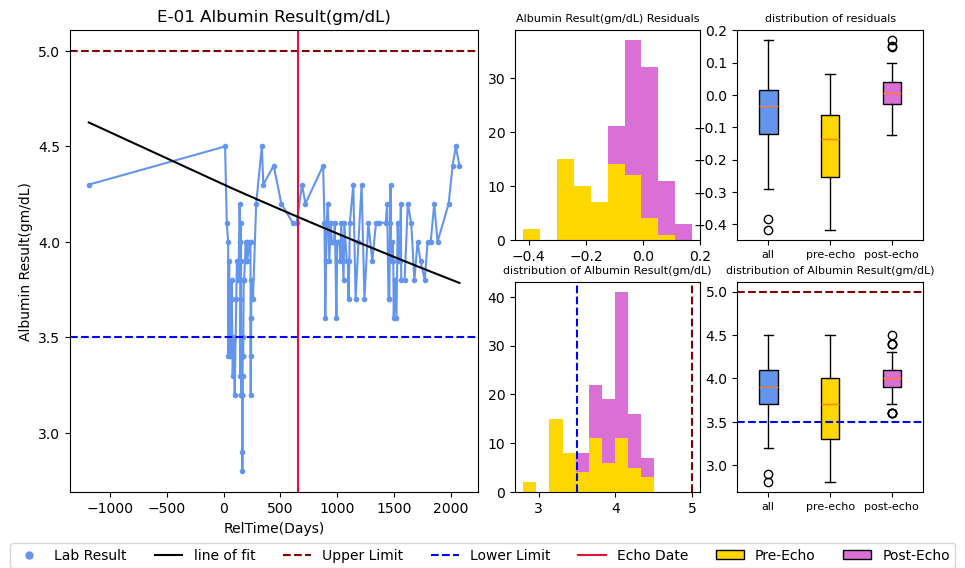

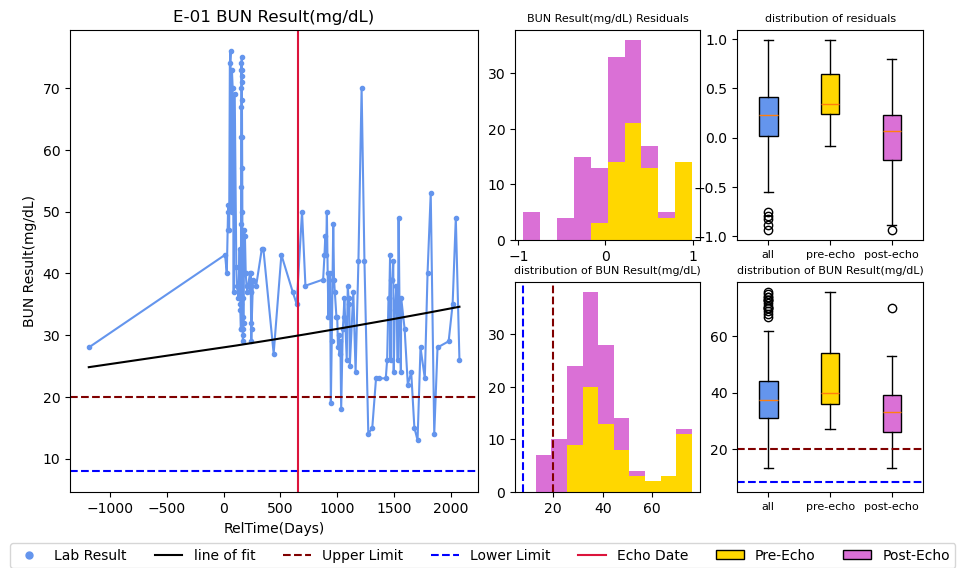

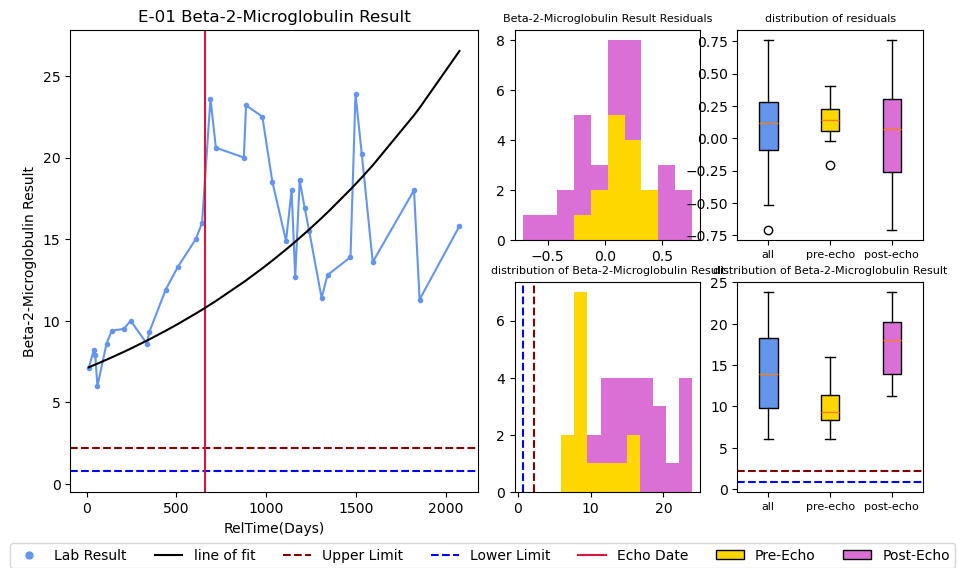

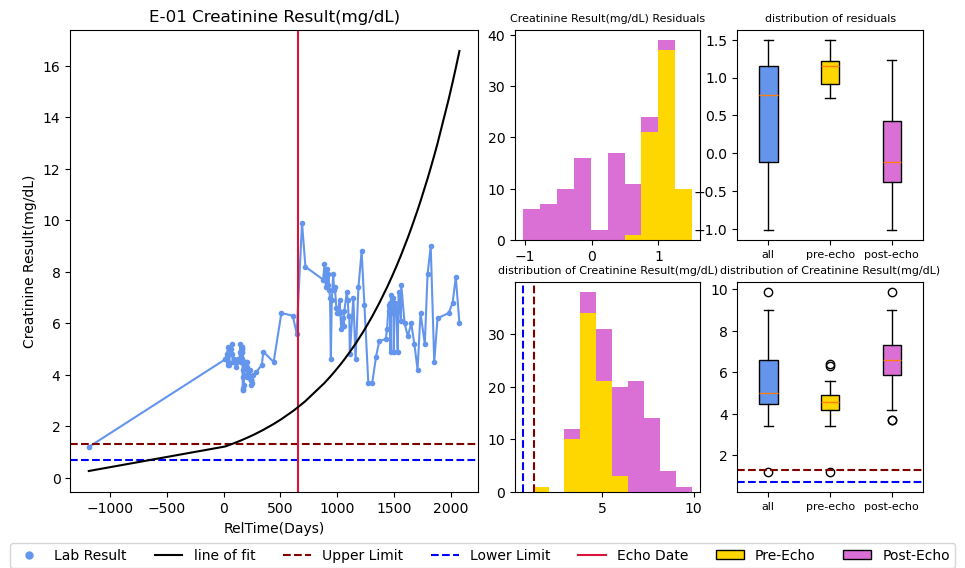

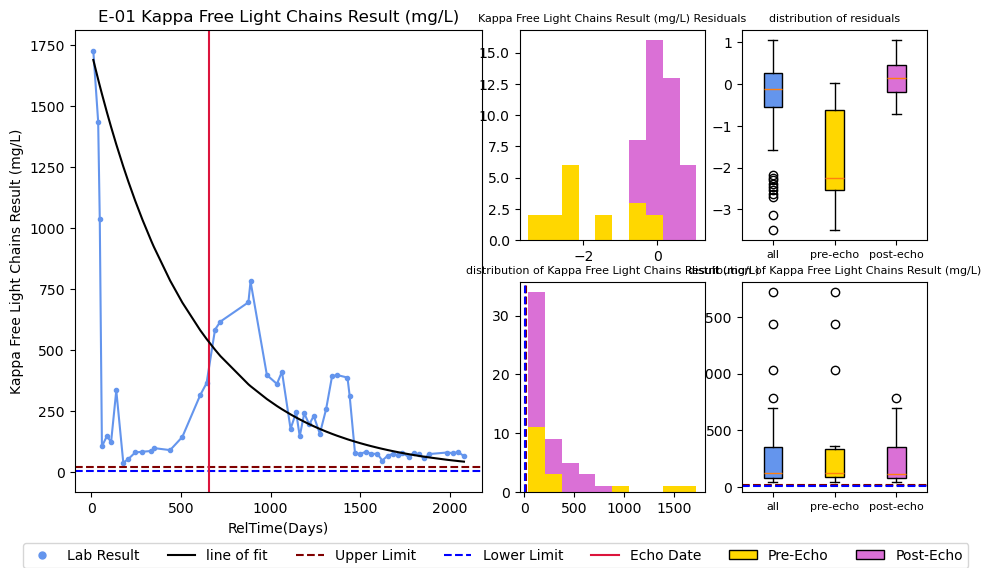

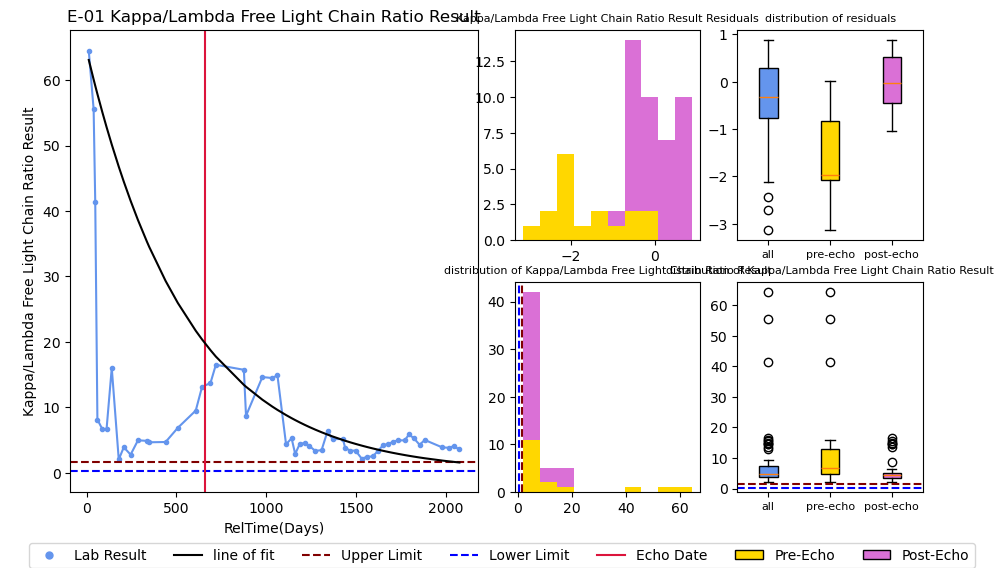

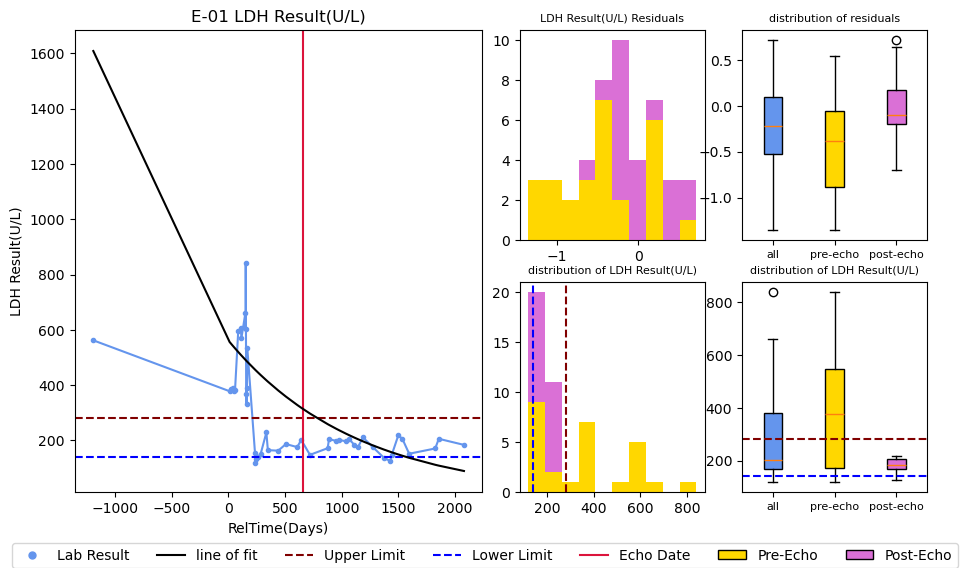

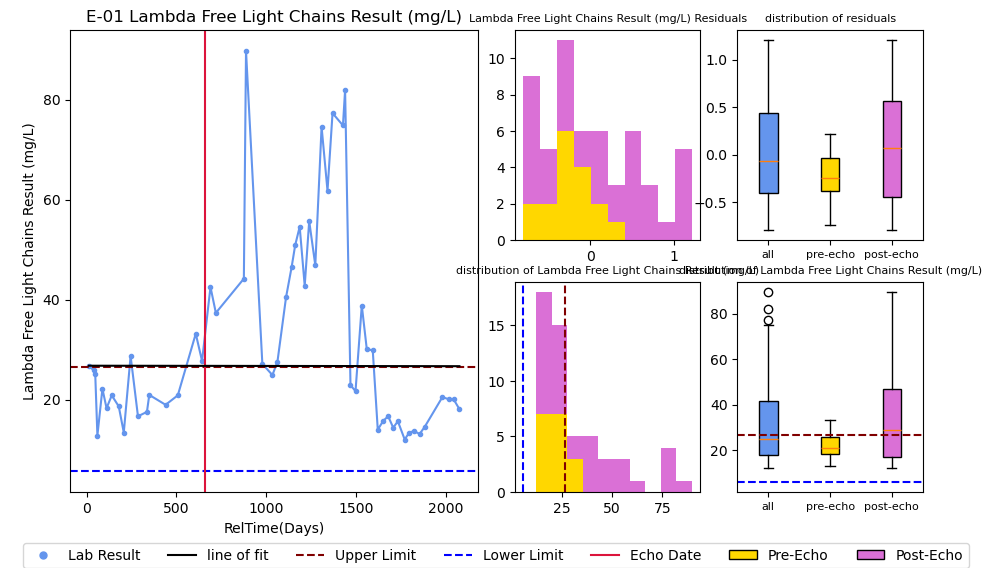

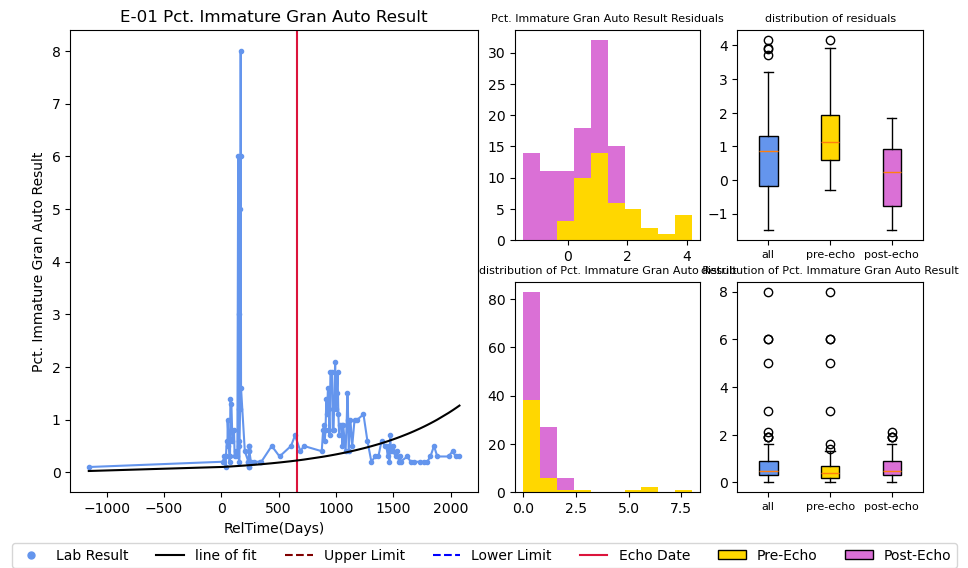

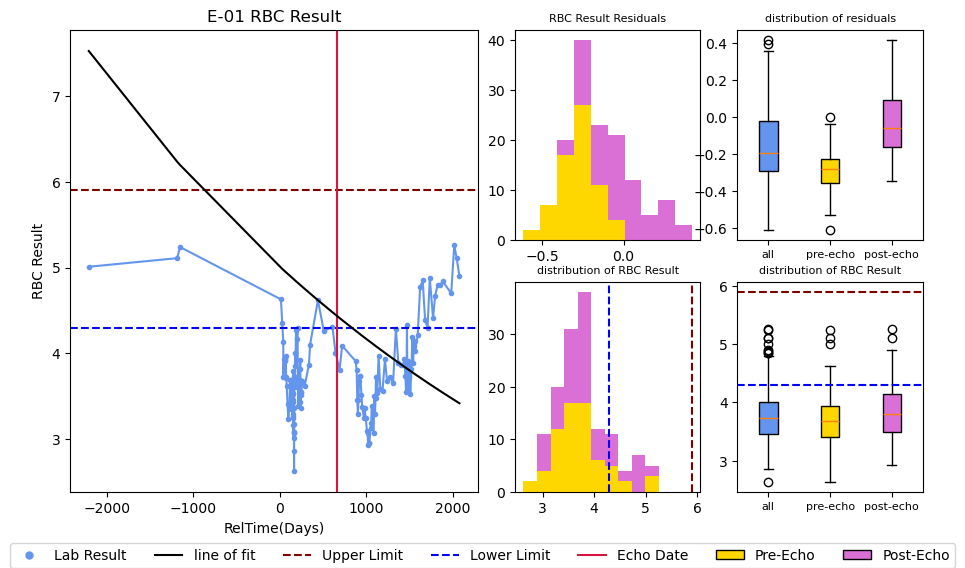

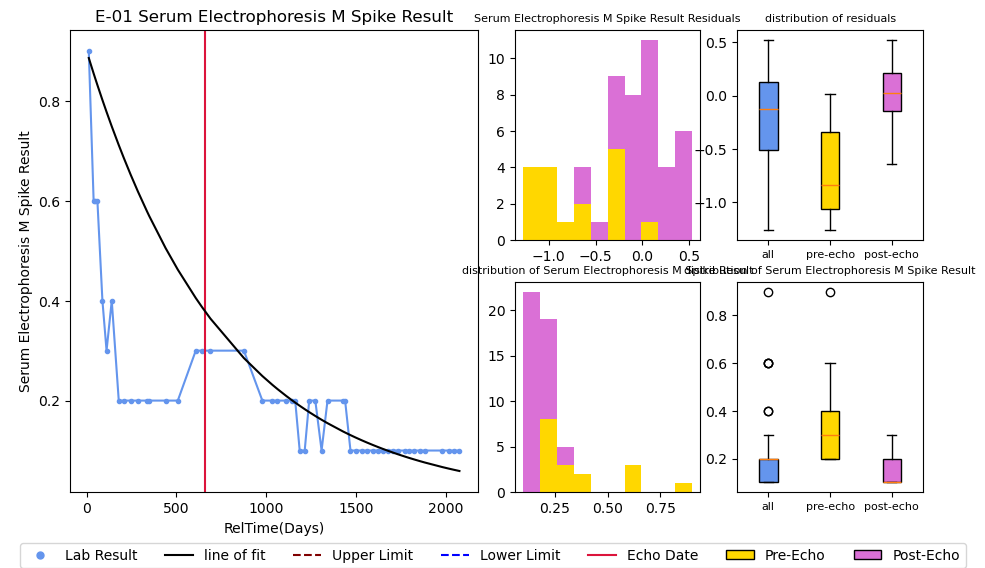

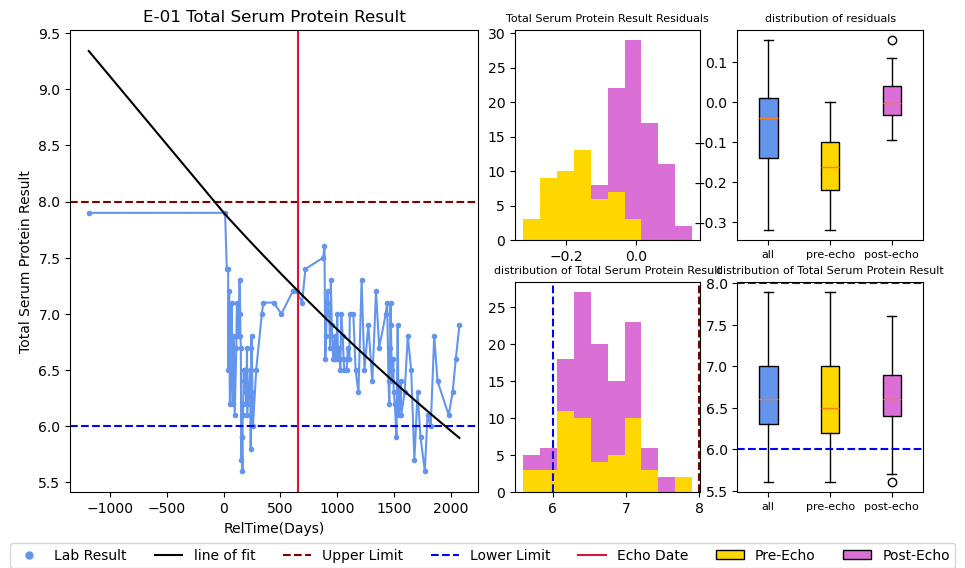

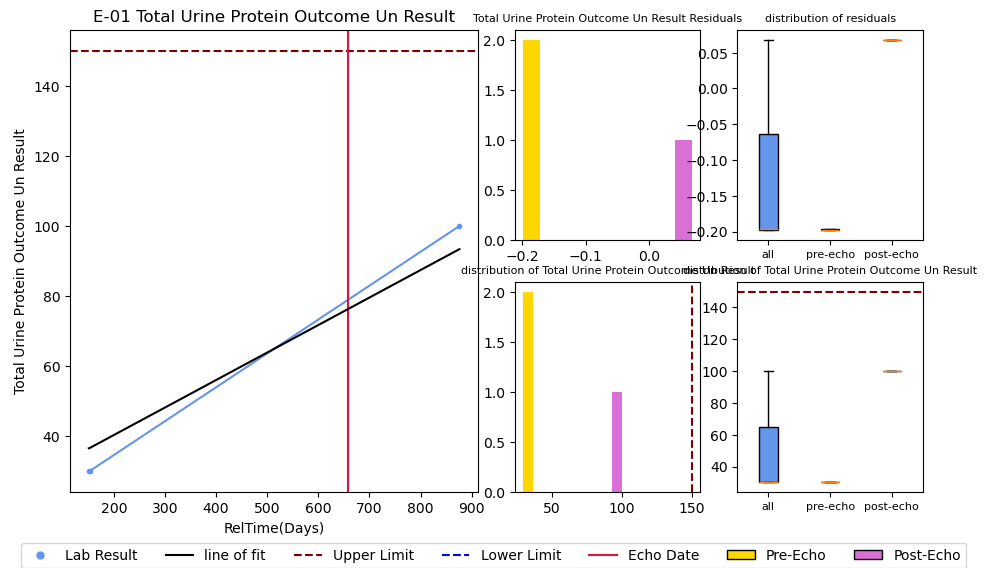

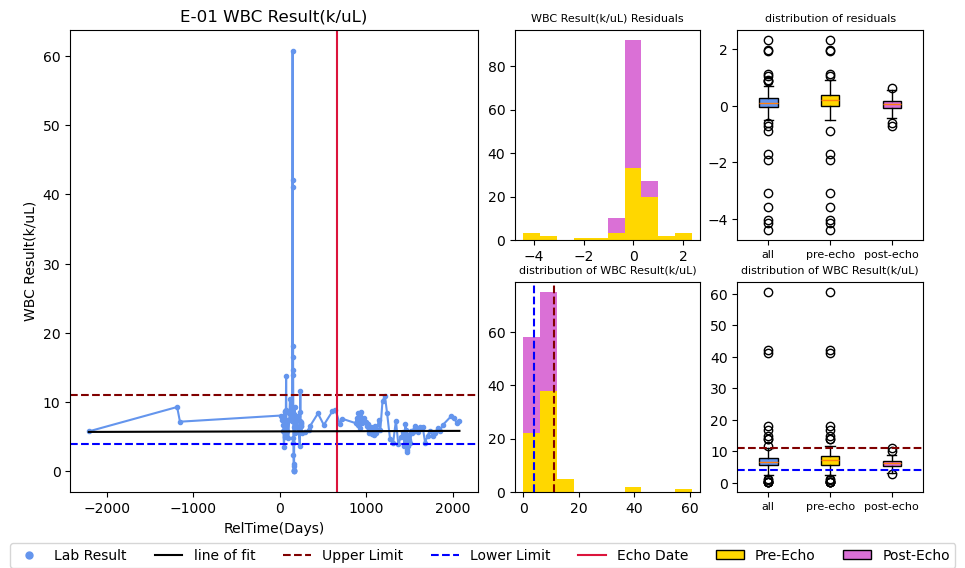

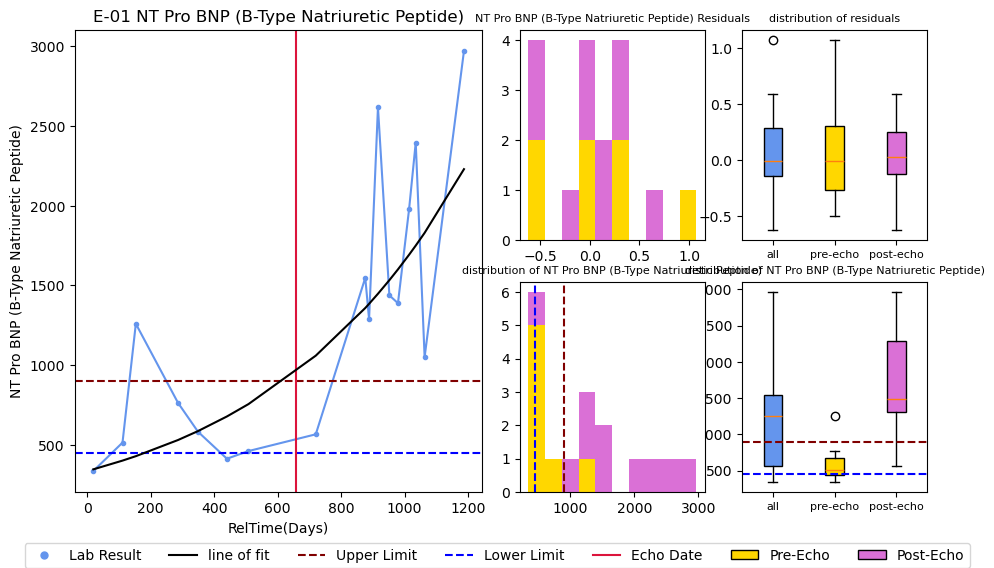

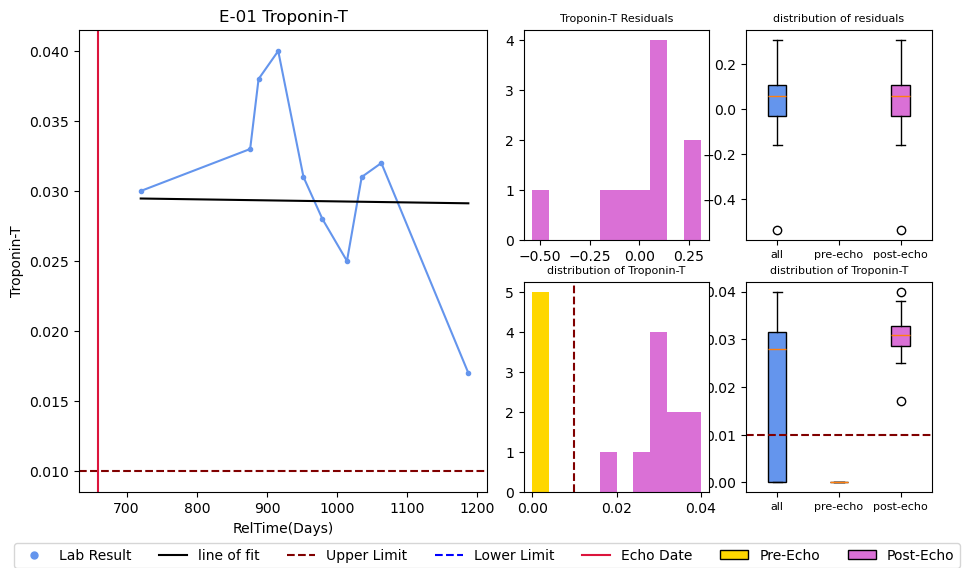

In [28]:
#call a particular lab single patient linear model
for lab in listOfLabs: 
    model_type = "ln transformed data linear fit"
    y_column_name = lab
    df_Labs_results_2 = df_Labs_filtered[[x_column_name, y_column_name]]

    #drop rows were there is either Null or 0 data.  This must be done as a dataframe so that the data remains the same length 
    df_Labs_filtered_notNA = df_Labs_results_2.dropna(axis='rows') #drops the row if either time or lab result are missing

    #first remove any y which is negative
    df_Labs_filtered_notNA_2 = df_Labs_filtered_notNA.loc[df_Labs_filtered_notNA[y_column_name] > 0]

    #get the x values to an array --> this is time
    x_values = df_Labs_filtered_notNA_2[[x_column_name]]

    #get the y values to an array --> these are the lab results
    y_values_raw = df_Labs_filtered_notNA_2[y_column_name]

    #check the length of the data
    dataLength = len(y_values_raw)

    if dataLength > 2: 
        #find the starting value at baseline
        y_values_transformed = np.log(y_values_raw)
        ptBaseline2 = y_values_transformed.iloc[0]
        y_values_adjusted = y_values_transformed - ptBaseline2
        y_values = y_values_adjusted
        #flattening data so you can work with it in curve fit 
        x_flat = x_values.squeeze()
        y_flat = y_values.squeeze()

        # Fit the model to the adjusted data
        popt, pcov = curve_fit(linear_model_forceB, x_flat, y_flat)

        # get properties
        m = popt[0]

        # Create predicted values for assessing the quality of the fit
        #these values are still ln transformed and shifted.  compare to y_values
        y_predict = linear_model_forceB(x_values, m) #+ ptBaseline2

        # adjust the predicted values by adding the baseline and 
        # converting back to the original units 
        y_predict_ln = np.exp((y_predict) + ptBaseline2) 

        #calc R^2
        r_squared = r2_score(y_flat, y_predict)

        #calc residual error (mean squared error)
        residual_error = mean_squared_error(y_flat, y_predict)
        
        residuals = y_values - y_predict.squeeze()
        residualsIndex = x_values.squeeze()
        residuals = residuals.set_axis(residualsIndex)

        #assigning the parameters to a dataframe to place into
        regression_parameters = {
            'patient ID' : ptID_test,
            'lab' : lab,
            'model type' : model_type,
            'number of data points': dataLength,
            'coef A' : m,
            'intercpet': ptBaseline2, 
            'R2' : r_squared, 
            'residual error': residual_error
        }

        #including a plot of the data 
        #generate the figure and axis here so that it is dependent upon data existing
        fig = plt.figure(figsize= (11,6))
        axs=plt.subplot2grid((2,4), (0,0), rowspan=2, colspan=2) 
        #plot the data
        axs.plot(x_values, y_values_raw, color = labcolor,
                    marker =labmarker)
        if lab in list(dictUpperLimit.keys()):
                #if the lab has an upper limit
                upperlimit = dictUpperLimit[lab]
                axs.axhline(y = upperlimit, linestyle = 'dashed', color = upperlimitcolor)
        if lab in list(dictLowerLimit.keys()):
                lowerlimit = dictLowerLimit[lab]
                axs.axhline(y=lowerlimit, linestyle = 'dashed', color = lowerlimitcolor)
        if ptID_test in list(echoDates.keys()):        #plot a vertical line for the echo
                #the echoDates have been cleaned to remove non-numerical data
                patientEchoDate = echoDates[ptID_test]
                echoDate_toplot = float(patientEchoDate) *30.4 #convert to days
                axs.axvline(x = echoDate_toplot, color =echocolor)
        #plot the fit 
        axs.plot(x_values, y_predict_ln, color = fitcolor)
        axs.set_title(ptID_test + " "+ lab)
        axs.set_ylabel(lab)
        axs.set_xlabel(x_column_name)

        #making a legend 
        labmarker_line = plt.Line2D([0], [0], linestyle='none', marker=labmarker, color=labcolor, markersize=10, label=f'Lab Result')
        upperlimitmarker_line = plt.Line2D([0], [0], linestyle='dashed', color=upperlimitcolor, markersize=10, label=f'Upper Limit')
        lowerlimitmarker_line = plt.Line2D([0], [0], linestyle='dashed', color=lowerlimitcolor, markersize=10, label=f'Lower Limit')
        lineOfFit_line = plt.Line2D([0], [0], linestyle='-', color=fitcolor, markersize=10, label=f'line of fit')
        echo_line = plt.Line2D([0], [0], linestyle='-', color=echocolor, markersize=10, label=f'Echo Date')
        pre_patch = mpatches.Patch(facecolor= pre_echocolor, edgecolor='black', label=f'Pre-Echo')
        post_patch = mpatches.Patch(facecolor= post_echocolor, edgecolor='black', label=f'Post-Echo')
        # echo_patch = mpatches.Patch(facecolor= echocolor, edgecolor='black', label=f'Echo')
        # Add all patches and lines to the legend
        handles = [labmarker_line, lineOfFit_line, upperlimitmarker_line, lowerlimitmarker_line, echo_line, pre_patch, post_patch]
        fig.legend(handles=handles, loc='lower center', ncols=7, borderaxespad = 0., frameon=True)

        #segmenting the data by the echo date for graphing the residuals
        PreEcho = df_Labs_filtered_notNA.loc[df_Labs_filtered_notNA[x_column_name] <= echoDate_toplot] #only if pt has an echo
        boxPreEcho = PreEcho[y_column_name]
        PostEcho = df_Labs_filtered_notNA.loc[df_Labs_filtered_notNA[x_column_name] > echoDate_toplot]
        boxPostEcho =PostEcho[y_column_name]

        #plotting histogram of residuals
        axs2 = plt.subplot2grid((2,4), (0,2))
        PreEcho_residuals = residuals.loc[residuals.index <= echoDate_toplot] #only if pt has an echo
        PostEcho_residuals = residuals.loc[residuals.index > echoDate_toplot]
        axs2.hist([PreEcho_residuals, PostEcho_residuals],
                label = ['pre-echo', 'post-echo'], color =['gold', 'orchid'], stacked = True)
        axs2.set_title(lab + " Residuals", fontsize = 8)


        #boxplot of the raw data pre and post echo
        ax3 = plt.subplot2grid((2,4), (1,3))
        boxAllData = df_Labs_filtered_notNA[y_column_name]
        boxToPlot = [boxAllData, boxPreEcho, boxPostEcho]
        colorsbox = [labcolor, pre_echocolor, post_echocolor]
        boxplot = ax3.boxplot(boxToPlot, patch_artist=True)
        if lab in list(dictUpperLimit.keys()):
                #if the lab has an upper limit
                upperlimit = dictUpperLimit[lab]
                ax3.axhline(y = upperlimit, linestyle = 'dashed', color = upperlimitcolor)
        if lab in list(dictLowerLimit.keys()):
                lowerlimit = dictLowerLimit[lab]
                ax3.axhline(y=lowerlimit, linestyle = 'dashed', color = lowerlimitcolor)
        for patch, color in zip(boxplot['boxes'], colorsbox):
            patch.set_facecolor(color)
        ax3.set_xticklabels(["all", "pre-echo", "post-echo"], fontsize = 8)
        ax3.set_title("distribution of " + lab, fontsize = 8)

        #boxplot of the residuals pre and post echo
        ax5 = plt.subplot2grid((2,4), (0,3))
        boxAllDataResiduals = residuals
        boxPreEchoResiduals = PreEcho_residuals
        boxPostEchoResiduals = PostEcho_residuals
        boxToPlot = [boxAllDataResiduals, boxPreEchoResiduals, boxPostEchoResiduals]
        colorsbox = [labcolor, pre_echocolor, post_echocolor]
        boxplot = ax5.boxplot(boxToPlot, patch_artist=True)
        for patch, color in zip(boxplot['boxes'], colorsbox):
            patch.set_facecolor(color)
        ax5.set_xticklabels(["all", "pre-echo", "post-echo"], fontsize = 8)
        ax5.set_title("distribution of residuals", fontsize = 8)

        #plotting histogram of the raw data pre and post echo
        ax4 = plt.subplot2grid((2,4), (1,2))
        ax4.hist([PreEcho[y_column_name], PostEcho[y_column_name]],
                label = ['pre-echo', 'post-echo'], color =['gold', 'orchid'], stacked = True)
        if lab in list(dictUpperLimit.keys()):
                #if the lab has an upper limit
                upperlimit = dictUpperLimit[lab]
                ax4.axvline(x = upperlimit, linestyle = 'dashed', color = upperlimitcolor)
        if lab in list(dictLowerLimit.keys()):
                lowerlimit = dictLowerLimit[lab]
                ax4.axvline(x=lowerlimit, linestyle = 'dashed', color = lowerlimitcolor)
        ax4.set_title("distribution of " + lab, fontsize = 8)

    else:
        #not enough data to perform regression
        regression_parameters = {
            'patient ID' : ptID_test,
            'lab' : lab,
            'model type' : model_type,
            'number of data points': dataLength,
            'coef A' : 'unable to calculate',
            'intercpet': 'unable to calculate', 
            'R2' : 'unable to calculate',
            'residual error': 'unable to calculate'
        }
    #saving the parameters to a dataframe for a single patient
    df_parameters_linearRegression = df_parameters_linearRegression._append(regression_parameters, ignore_index=True)

    # figFolder = makeFolderPathForData(parent_dir_fig2, folderName_header= ptID_test,
    #                                   folderName_common="-lnfits", folderName_suffix="_2024-06_24-v1")

    # fighpathcomplete = outputFiguresPath(fileName_header= ptID_test, fileName_mid= lab, fileName_suff= fileName_suff_fig,
    #               parent_dir=parent_dir_fig2, folderName= figFolder)
    # plt.savefig(fighpathcomplete, bbox_inches = 'tight')


using curve fit to force the intercept to patient baseline for all pts in directory

In [29]:
#style elements for plots

#colors
labcolor = "cornflowerblue"
echocolor = "crimson"
fitcolor = "black"

pre_echocolor = "gold"
post_echocolor = "orchid"

upperlimitcolor = "maroon"
lowerlimitcolor = "blue"

#markers 
labmarker = "."

# dataOut_sheetName = "quadratic-Forced-20240624"

In [26]:
# #locations for the ouput figures
# #for figures
# parent_dir_fig = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/013 Analyzed Data outputs"
# folderName_QuadFitFigures = makeFolderPathForData(parent_dir_fig, "FitFig-", "quad-Force", "_2024-06-24-v1")
# parent_dir_fig2 = os.path.join(parent_dir_fig, folderName_QuadFitFigures)
# # fileName_header_fig = #patient ID
# # fileName_mid_fig = #lab name
# fileName_suff_fig = "-quadFit-Force-Fig"
# #output figures
# # outputFiguresPath(fileName_header= fileName_header_fig, fileName_mid= fileName_mid_fig, fileName_suff= fileName_suff_fig,
# #                   parent_dir=parent_dir_fig2, folderName= make a folder)

In [27]:
# Define model systems
def quadratic_model_force(x, a, b):
    return a * x **2 + b*x 



In [35]:
#loop through all patients in a folder and all labs from the list of labs
for ptID_test in list(patientDictLabs.keys()):
    #for saving the data created in the loop to a dataframe
    regression_parameters = {
        'patient ID' : ['test'],
        'lab' : ['test'],
        'model type' : ['test'],
        'number of data points': ["test"],
        'coef A' : ['test'],
        'intercpet': ['test'], 
        'R2' : ['test'], 
        'residual error': ['test']
    }
    df_parameters_linearRegression = pd.DataFrame.from_dict(regression_parameters)

    #get all the x and y values as a data frame
    df_Labs_filtered = dictOfFilteredLabs[ptID_test]

    #get the list of labs filtered for the patient 
    columnNames_filtered = list(df_Labs_filtered.columns)

    #removing the time column for iteration list 
    columnNames_filtered.remove(x_column_name)
    listOfLabs = columnNames_filtered

    for lab in listOfLabs: 
        model_type = "ln transformed linear fit with baseline shift"
        y_column_name = lab
        df_Labs_results_2 = df_Labs_filtered[[x_column_name, y_column_name]]

        #drop rows were there is either Null or 0 data.  This must be done as a dataframe so that the data remains the same length 
        df_Labs_filtered_notNA = df_Labs_results_2.dropna(axis='rows') #drops the row if either time or lab result are missing

        #first remove any y which is negative, this is likely not needed for this model
        df_Labs_filtered_notNA_2 = df_Labs_filtered_notNA.loc[df_Labs_filtered_notNA[y_column_name]> 0]

        #get the x values to an array --> this is time
        x_values = df_Labs_filtered_notNA_2[[x_column_name]]

        #get the y values to an array --> these are the lab results
        y_values_raw = df_Labs_filtered_notNA_2[y_column_name]

        #check the length of the data
        dataLength = len(y_values_raw)

        if dataLength > 2: 
            #find the starting value at baseline
            y_values_transformed = np.log(y_values_raw)
            ptBaseline2 = y_values_transformed.iloc[0]
            y_values_adjusted = y_values_transformed - ptBaseline2
            y_values = y_values_adjusted
            #flattening data so you can work with it in curve fit 
            x_flat = x_values.squeeze()
            y_flat = y_values.squeeze()

            # Fit the model to the adjusted data
            popt, pcov = curve_fit(linear_model_forceB, x_flat, y_flat)

            # get properties
            m = popt[0]

            # Create the linear fit for calculating quality of fit
            #these values are still ln transformed and shifted, compare to y_values
            y_predict = linear_model_forceB(x_values, m) #+ ptBaseline2

            # adjust the predicted values by adding the baseline and 
            # converting back to the original units
            y_predict_ln = np.exp((y_predict) + ptBaseline2) 

            #calc R^2
            r_squared = r2_score(y_flat, y_predict)

            #calc residual error (mean squared error)
            residual_error = mean_squared_error(y_flat, y_predict)
            
            residuals = y_values - y_predict.squeeze()
            residualsIndex = x_values.squeeze()
            residuals = residuals.set_axis(residualsIndex)

            #assigning the parameters to a dataframe to place into
            regression_parameters = {
                'patient ID' : ptID_test,
                'lab' : lab,
                'model type' : model_type,
                'number of data points': dataLength,
                'coef A' : m,
                'intercpet': ptBaseline2, 
                'R2' : r_squared, 
                'residual error': residual_error
            }

            #including a plot of the data 
            #generate the figure and axis here so that it is dependent upon data existing
            fig = plt.figure(figsize= (11,6))
            axs=plt.subplot2grid((2,4), (0,0), rowspan=2, colspan=2) 
            #plot the data
            axs.plot(x_values, y_values_raw, color = labcolor,
                        marker =labmarker)
            if lab in list(dictUpperLimit.keys()):
                    #if the lab has an upper limit
                    upperlimit = dictUpperLimit[lab]
                    axs.axhline(y = upperlimit, linestyle = 'dashed', color = upperlimitcolor)
            if lab in list(dictLowerLimit.keys()):
                    lowerlimit = dictLowerLimit[lab]
                    axs.axhline(y=lowerlimit, linestyle = 'dashed', color = lowerlimitcolor)
            if ptID_test in list(echoDates.keys()):        #plot a vertical line for the echo
                    #the echoDates have been cleaned to remove non-numerical data
                    patientEchoDate = echoDates[ptID_test]
                    echoDate_toplot = float(patientEchoDate) *30.4 #convert to days
                    axs.axvline(x = echoDate_toplot, color =echocolor)
            #plot the fit 
            axs.plot(x_values, y_predict_ln, color = fitcolor)
            axs.set_title(ptID_test + " "+ lab)
            axs.set_ylabel(lab)
            axs.set_xlabel(x_column_name)

            #making a legend 
            labmarker_line = plt.Line2D([0], [0], linestyle='none', marker=labmarker, color=labcolor, markersize=10, label=f'Lab Result')
            upperlimitmarker_line = plt.Line2D([0], [0], linestyle='dashed', color=upperlimitcolor, markersize=10, label=f'Upper Limit')
            lowerlimitmarker_line = plt.Line2D([0], [0], linestyle='dashed', color=lowerlimitcolor, markersize=10, label=f'Lower Limit')
            lineOfFit_line = plt.Line2D([0], [0], linestyle='-', color=fitcolor, markersize=10, label=f'line of fit')
            echo_line = plt.Line2D([0], [0], linestyle='-', color=echocolor, markersize=10, label=f'Echo Date')
            pre_patch = mpatches.Patch(facecolor= pre_echocolor, edgecolor='black', label=f'Pre-Echo')
            post_patch = mpatches.Patch(facecolor= post_echocolor, edgecolor='black', label=f'Post-Echo')
            # echo_patch = mpatches.Patch(facecolor= echocolor, edgecolor='black', label=f'Echo')
            # Add all patches and lines to the legend
            handles = [labmarker_line, lineOfFit_line, upperlimitmarker_line, lowerlimitmarker_line, echo_line, pre_patch, post_patch]
            fig.legend(handles=handles, loc='lower center', ncols=7, borderaxespad = 0., frameon=True)

            #segmenting the data by the echo date for graphing the residuals
            PreEcho = df_Labs_filtered_notNA.loc[df_Labs_filtered_notNA[x_column_name] <= echoDate_toplot] #only if pt has an echo
            boxPreEcho = PreEcho[y_column_name]
            PostEcho = df_Labs_filtered_notNA.loc[df_Labs_filtered_notNA[x_column_name] > echoDate_toplot]
            boxPostEcho =PostEcho[y_column_name]

            #plotting histogram of residuals
            axs2 = plt.subplot2grid((2,4), (0,2))
            PreEcho_residuals = residuals.loc[residuals.index <= echoDate_toplot] #only if pt has an echo
            PostEcho_residuals = residuals.loc[residuals.index > echoDate_toplot]
            axs2.hist([PreEcho_residuals, PostEcho_residuals],
                    label = ['pre-echo', 'post-echo'], color =['gold', 'orchid'], stacked = True)
            axs2.set_title(lab + " Residuals", fontsize = 8)


            #boxplot of the raw data pre and post echo
            ax3 = plt.subplot2grid((2,4), (1,3))
            boxAllData = df_Labs_filtered_notNA[y_column_name]
            boxToPlot = [boxAllData, boxPreEcho, boxPostEcho]
            colorsbox = [labcolor, pre_echocolor, post_echocolor]
            boxplot = ax3.boxplot(boxToPlot, patch_artist=True)
            if lab in list(dictUpperLimit.keys()):
                    #if the lab has an upper limit
                    upperlimit = dictUpperLimit[lab]
                    ax3.axhline(y = upperlimit, linestyle = 'dashed', color = upperlimitcolor)
            if lab in list(dictLowerLimit.keys()):
                    lowerlimit = dictLowerLimit[lab]
                    ax3.axhline(y=lowerlimit, linestyle = 'dashed', color = lowerlimitcolor)
            for patch, color in zip(boxplot['boxes'], colorsbox):
                patch.set_facecolor(color)
            ax3.set_xticklabels(["all", "pre-echo", "post-echo"], fontsize = 8)
            ax3.set_title("distribution of " + lab, fontsize = 8)

            #boxplot of the residuals pre and post echo
            ax5 = plt.subplot2grid((2,4), (0,3))
            boxAllDataResiduals = residuals
            boxPreEchoResiduals = PreEcho_residuals
            boxPostEchoResiduals = PostEcho_residuals
            boxToPlot = [boxAllDataResiduals, boxPreEchoResiduals, boxPostEchoResiduals]
            colorsbox = [labcolor, pre_echocolor, post_echocolor]
            boxplot = ax5.boxplot(boxToPlot, patch_artist=True)
            for patch, color in zip(boxplot['boxes'], colorsbox):
                patch.set_facecolor(color)
            ax5.set_xticklabels(["all", "pre-echo", "post-echo"], fontsize = 8)
            ax5.set_title("distribution of residuals", fontsize = 8)

            #plotting histogram of the raw data pre and post echo
            ax4 = plt.subplot2grid((2,4), (1,2))
            ax4.hist([PreEcho[y_column_name], PostEcho[y_column_name]],
                    label = ['pre-echo', 'post-echo'], color =['gold', 'orchid'], stacked = True)
            if lab in list(dictUpperLimit.keys()):
                    #if the lab has an upper limit
                    upperlimit = dictUpperLimit[lab]
                    ax4.axvline(x = upperlimit, linestyle = 'dashed', color = upperlimitcolor)
            if lab in list(dictLowerLimit.keys()):
                    lowerlimit = dictLowerLimit[lab]
                    ax4.axvline(x=lowerlimit, linestyle = 'dashed', color = lowerlimitcolor)
            ax4.set_title("distribution of " + lab, fontsize = 8)

        else:
            #not enough data to perform regression
            regression_parameters = {
                'patient ID' : ptID_test,
                'lab' : lab,
                'model type' : model_type,
                'number of data points': dataLength,
                'coef A' : 'unable to calculate',
                'intercpet': 'unable to calculate', 
                'R2' : 'unable to calculate',
                'residual error': 'unable to calculate'
            }
        #saving the parameters to a dataframe for a single patient
        df_parameters_linearRegression = df_parameters_linearRegression._append(regression_parameters, ignore_index=True)

        figFolder = makeFolderPathForData(parent_dir_fig2, folderName_header= ptID_test,
                                        folderName_common="-exp-Force-fits", folderName_suffix="_2024-06_25-v1")

        fighpathcomplete = outputFiguresPath(fileName_header= ptID_test, fileName_mid= lab, fileName_suff= fileName_suff_fig,
                    parent_dir=parent_dir_fig2, folderName= figFolder)
        plt.savefig(fighpathcomplete, bbox_inches = 'tight')

        plt.close("all")

    #save the ouput data 
    #fileoutput 
    outputToExcel(df_data = df_parameters_linearRegression, fileName_header= ptID_test, fileName_Common= dataOut_common, fileName_suffix= dataOut_suffix,
                parent_dir= patientFitsDir, folderName=patientFitsFolder, sheetName= dataOut_sheetName)


C:\Users\maega\AppData\Local\Temp\ipykernel_54212\1430503965.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  echoDate_toplot = float(patientEchoDate) *30.4 #convert to days
C:\Users\maega\AppData\Local\Temp\ipykernel_54212\1430503965.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  echoDate_toplot = float(patientEchoDate) *30.4 #convert to days
C:\Users\maega\AppData\Local\Temp\ipykernel_54212\1430503965.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  echoDate_toplot = float(patientEchoDate) *30.4 #convert to days
C:\Users\maega\AppData\Local\Temp\ipykernel_54212\1430503965.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError 